In [1]:
cd ..

/home/janek/mag/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
import random
from sklearn import metrics
from src.reasoner_mod import *
from src.generate import load_dataset, prepare_data, reduce_dataset
from src.reasoner import *
from src.utils import *
from src.vis import *


In [3]:
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)


In [4]:
ts ='20240808T171513'

In [5]:
data_tr, data_vl, data_tr_p2, data_vl_p2, idx_te, X_te, y_te = prepare_data(data_tr, data_vl, data_te, seed, 5)

In [6]:
print(np.mean(data_tr[2]))
print(np.mean(data_vl[2]))
print()
print(np.mean(data_tr_p2[2]))
print(np.mean(data_vl_p2[2]))
print(np.mean(y_te))

0.21888727203492406
0.191374246405936

0.2203348305430788
0.18243243243243243
0.18631643249847282


In [7]:
print(len(data_tr[2]))
print(len(data_vl[2]))
print()
print(len(data_tr_p2[2]))
print(len(data_vl_p2[2]))
print(len(y_te))

73531
6469

36735
1628
1637


In [8]:
data_tr_p2 = reduce_dataset(data_tr_p2, len(test_onto), 1325, [idx_te, X_te, y_te])
data_tr = reduce_dataset(data_tr, len(train_onto), 1350, data_vl)
idx_te.extend(data_vl_p2[0])
X_te.extend(data_vl_p2[1])
y_te.extend(data_vl_p2[2])

In [9]:
print(np.mean(data_tr[2]))
print(np.mean(data_vl[2]))
print()
print(np.mean(data_tr_p2[2]))
print(np.mean(data_vl_p2[2]))
print(np.mean(y_te))

0.19148148148148147
0.191374246405936

0.18324528301886792
0.18243243243243243
0.18437978560490045


In [10]:
print(len(data_tr[2]))
print(len(data_vl[2]))
print()
print(len(data_tr_p2[2]))
print(len(y_te))

54000
6469

26500
3265


In [11]:
emb_size = 10
hidden_size = 16
epoch_count = 15
test_epoch_count = 10
batch_size = 32

In [12]:
reasoner_original = ReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
reasoner_original.load_state_dict(T.load('local/out/exp/20240808T171513/reasonerO.pt'))
reasoner_mod = ModifiedReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
reasoner_mod.load_state_dict(T.load('local/out/exp/20240808T171513/reasonerM.pt'))

<All keys matched successfully>

In [11]:
#FIRST PHASE
T.manual_seed(seed)
reasoner_original = ReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders_original = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]
print(f'created reasoner with {paramcount(reasoner_original)} parameters')
print(f'created {len(encoders_original)} encoders with {paramcount(encoders_original[0])} parameters each')

T.manual_seed(seed)
reasoner_mod = ModifiedReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders_mod = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]
print(f'created reasoner with {paramcount(reasoner_mod)} parameters')
print(f'created {len(encoders_mod)} encoders with {paramcount(encoders_mod[0])} parameters each')

train_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('original reasoner', reasoner_original), ('modified reasoner', reasoner_mod)]:
    print(reasoner_name)
    T.manual_seed(seed)
    random.seed(seed)
    if reasoner_name == 'original reasoner':
        train(data_tr, data_vl, reasoner, encoders_original, epoch_count=epoch_count, batch_size=batch_size, run_name=reasoner_name, logger=train_logger)
    else:
        train_mod(data_tr, data_vl, reasoner, encoders_mod, epoch_count=epoch_count, batch_size=batch_size, run_name=reasoner_name, logger=train_logger, identities_weight=0.028, identitity_weight_decay=0.96)


created reasoner with 3293 parameters
created 40 encoders with 1270 parameters each
created reasoner with 3283 parameters
created 40 encoders with 1270 parameters each
original reasoner
train epoch 00/15 | batch 1689/1688 | loss 0.7228 | val loss 0.7222 | acc 0.1912 | f1 0.3210 | prec 0.1912 | recall 0.9992 | roc auc 0.5402 | pr auc 0.2211 | elapsed 15.35s
train epoch 01/15 | batch 1689/1688 | loss 0.5656 | val loss 0.4631 | acc 0.8182 | f1 0.1158 | prec 0.8370 | recall 0.0622 | roc auc 0.6420 | pr auc 0.3258 | elapsed 53.57s
train epoch 02/15 | batch 1689/1688 | loss 0.4377 | val loss 0.4213 | acc 0.8221 | f1 0.2541 | prec 0.6426 | recall 0.1583 | roc auc 0.7599 | pr auc 0.4662 | elapsed 52.68s
train epoch 03/15 | batch 1689/1688 | loss 0.3458 | val loss 0.3820 | acc 0.8474 | f1 0.4633 | prec 0.7088 | recall 0.3441 | roc auc 0.8136 | pr auc 0.6090 | elapsed 52.87s
train epoch 04/15 | batch 1689/1688 | loss 0.2703 | val loss 0.3558 | acc 0.8694 | f1 0.5839 | prec 0.7478 | recall 0.4790

In [13]:
## --- SECOND PHASE
trained_test_encoders = {}
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('original reasoner', reasoner_original), ('modified reasoner', reasoner_mod)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    if reasoner_name == 'original reasoner':
        train(data_tr_p2, None, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)
    else:
        train_mod(data_tr_p2, None, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)


original reasoner
train epoch 00/10 | batch 830/829 | loss 1.4223 | val loss 1.4235 | acc 0.5911 | f1 0.3591 | prec 0.2519 | recall 0.6252 | roc auc 0.6655 | pr auc 0.4501 | elapsed 9.44s
train epoch 01/10 | batch 830/829 | loss 1.2210 | val loss 0.9868 | acc 0.6790 | f1 0.4179 | prec 0.3129 | recall 0.6289 | roc auc 0.7259 | pr auc 0.5150 | elapsed 19.93s
train epoch 02/10 | batch 830/829 | loss 0.8453 | val loss 0.6740 | acc 0.7595 | f1 0.4962 | prec 0.4026 | recall 0.6464 | roc auc 0.7862 | pr auc 0.5926 | elapsed 20.11s
train epoch 03/10 | batch 830/829 | loss 0.5845 | val loss 0.4699 | acc 0.8269 | f1 0.5851 | prec 0.5217 | recall 0.6662 | roc auc 0.8395 | pr auc 0.6776 | elapsed 19.11s
train epoch 04/10 | batch 830/829 | loss 0.4170 | val loss 0.3421 | acc 0.8745 | f1 0.6690 | prec 0.6473 | recall 0.6921 | roc auc 0.8815 | pr auc 0.7574 | elapsed 20.34s
train epoch 05/10 | batch 830/829 | loss 0.3129 | val loss 0.2632 | acc 0.9057 | f1 0.7363 | prec 0.7551 | recall 0.7183 | roc a

In [14]:
with T.no_grad():
    _, _, Y_te_orig = eval_batch(reasoner_original, trained_test_encoders['original reasoner'], X_te, y_te, idx_te)
    _, _, Y_te_mod = eval_batch(reasoner_mod, trained_test_encoders['modified reasoner'], X_te, y_te, idx_te)

In [15]:
base = 'local/out/exp/' + ts
df_tr = pd.read_csv(base+'/train.csv')
df_vl = pd.read_csv(base+'/valid.csv')

local/out/exp/20240808T171513


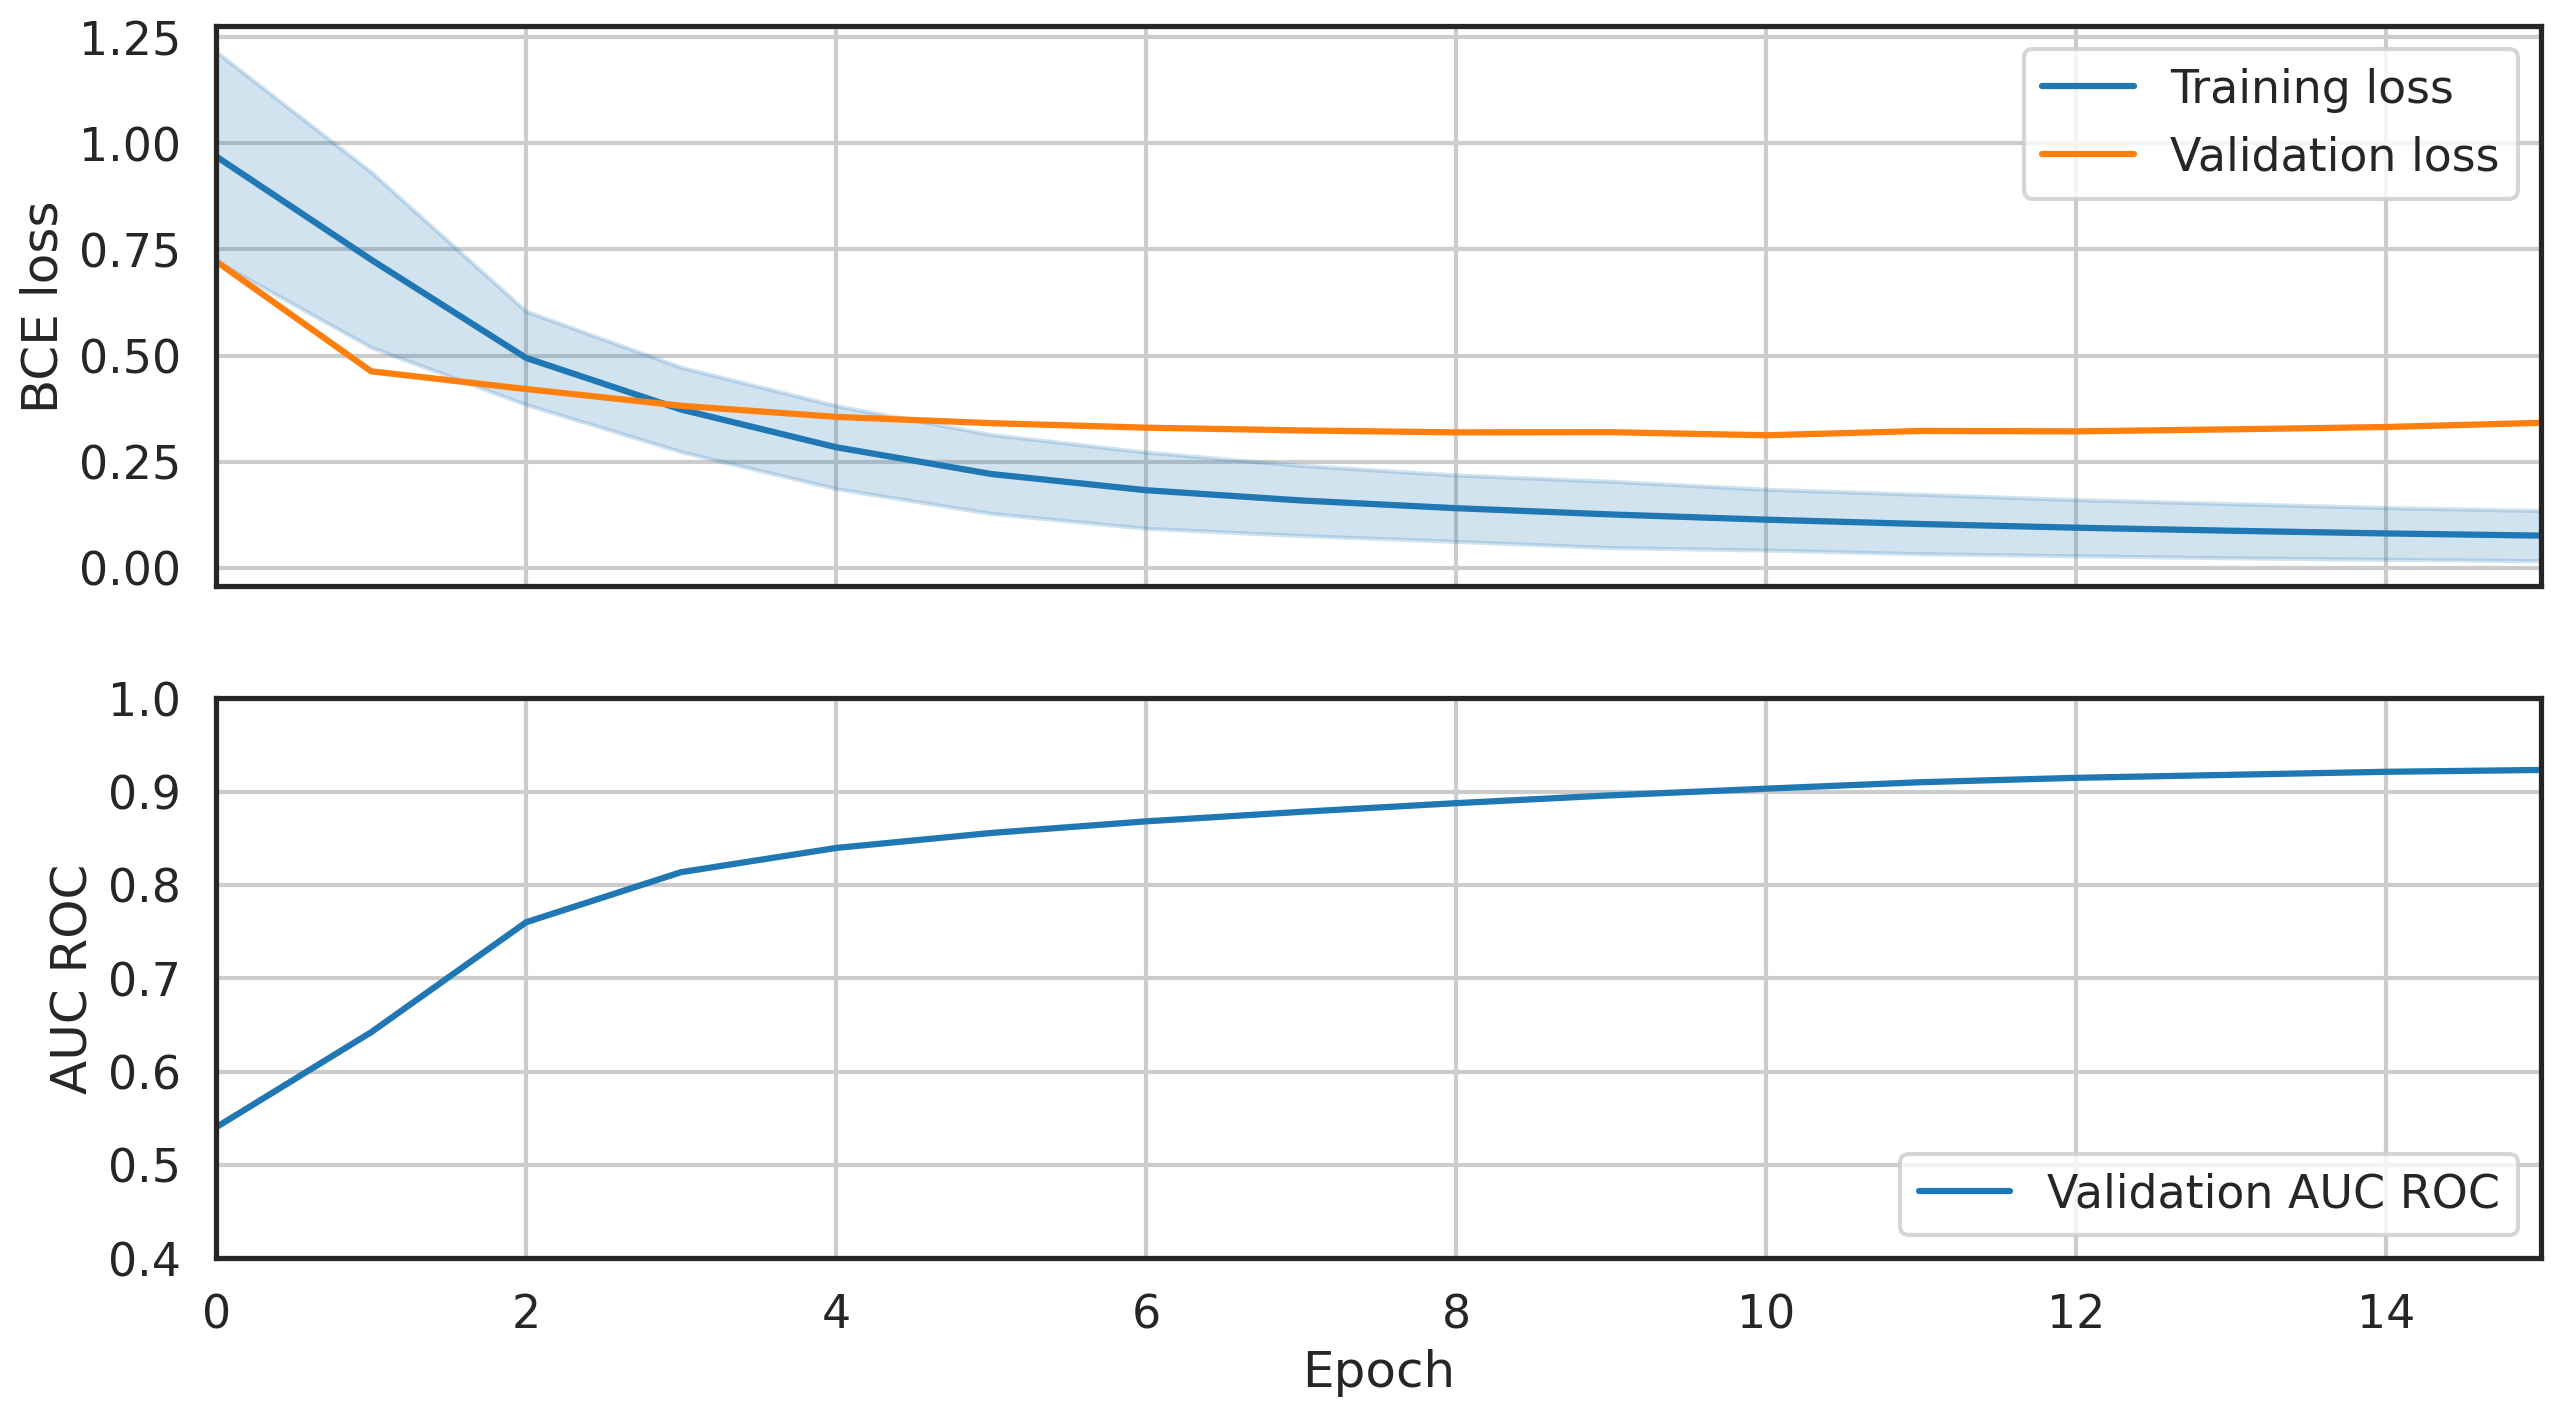

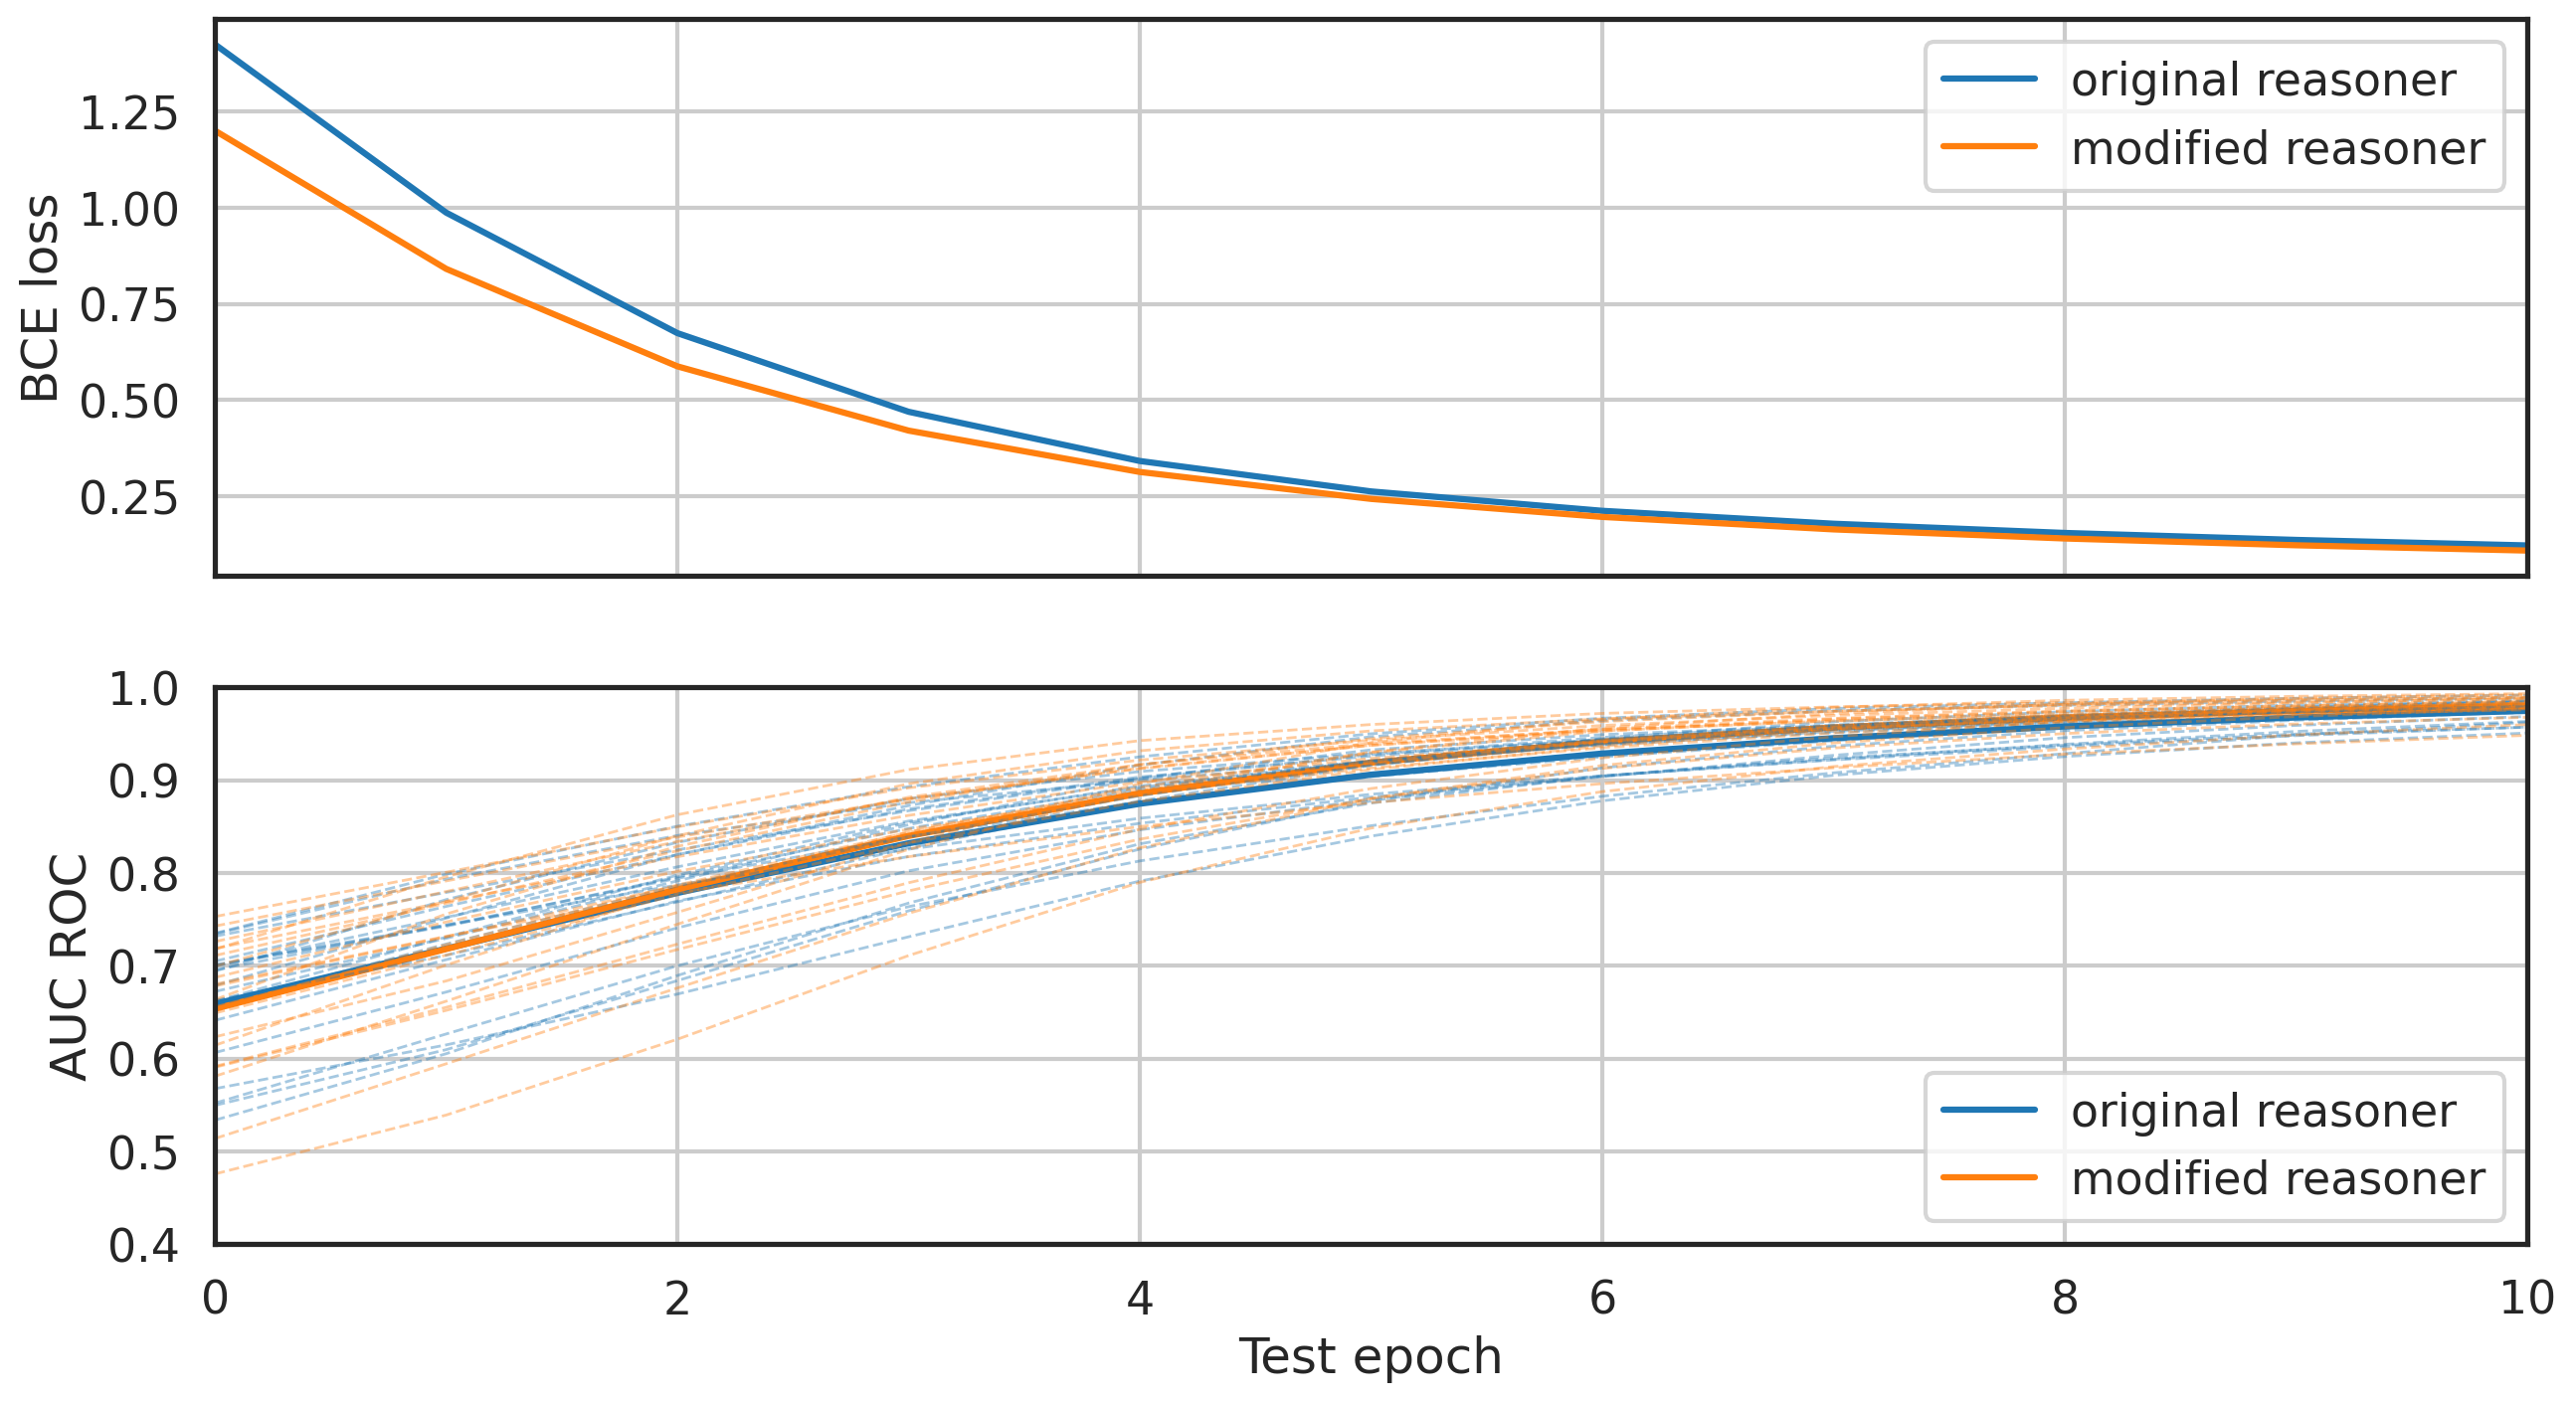

original
             mean       std     micro
acc      0.870230  0.044236  0.869832
prec     0.651056  0.126313  0.656637
recall   0.605250  0.139759  0.616279
f1       0.619362  0.113826  0.635818
auc_roc  0.859081  0.055703  0.865304
auc_pr   0.710687  0.109544  0.729528
modified
             mean       std     micro
acc      0.859910  0.035636  0.859724
prec     0.577592  0.117774  0.597561
recall   0.710221  0.122456  0.732558
f1       0.633496  0.112247  0.658209
auc_roc  0.884147  0.047978  0.889561
auc_pr   0.744674  0.108679  0.769043


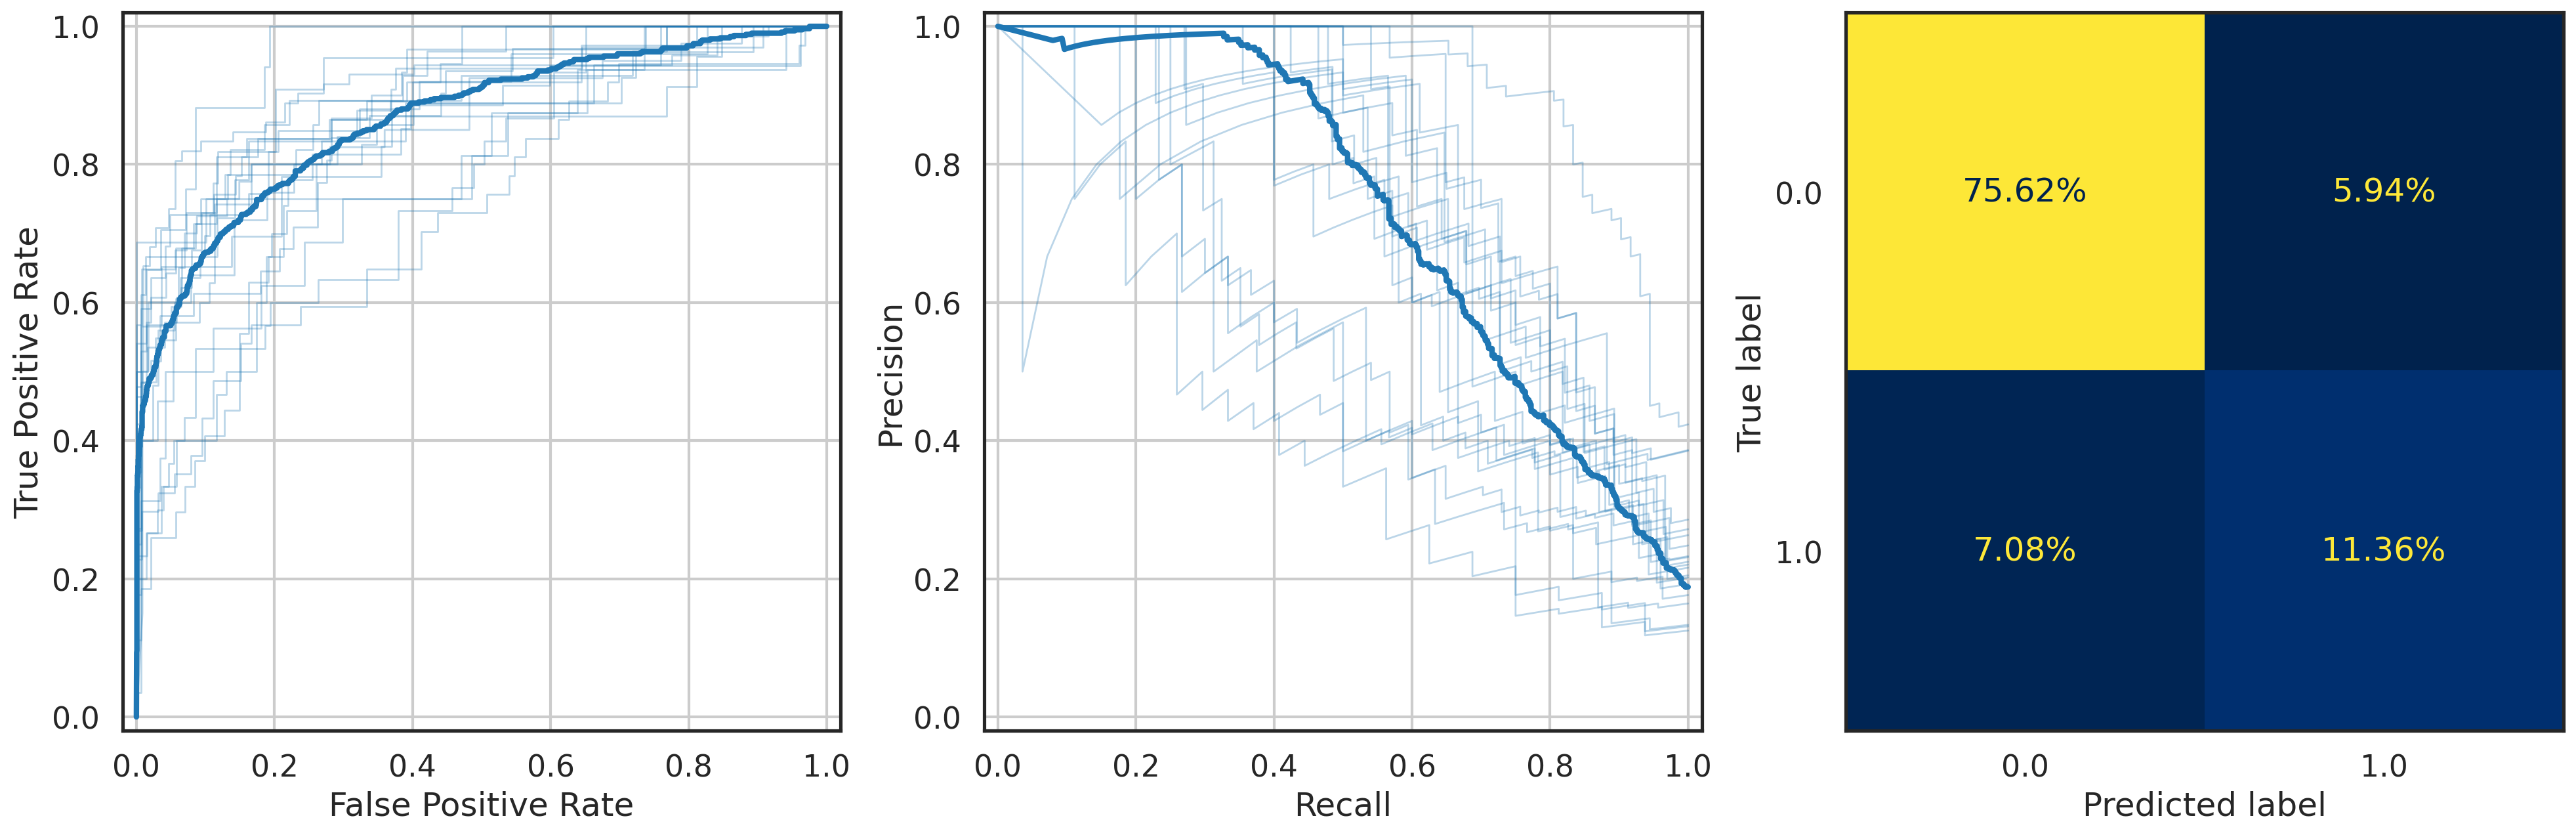

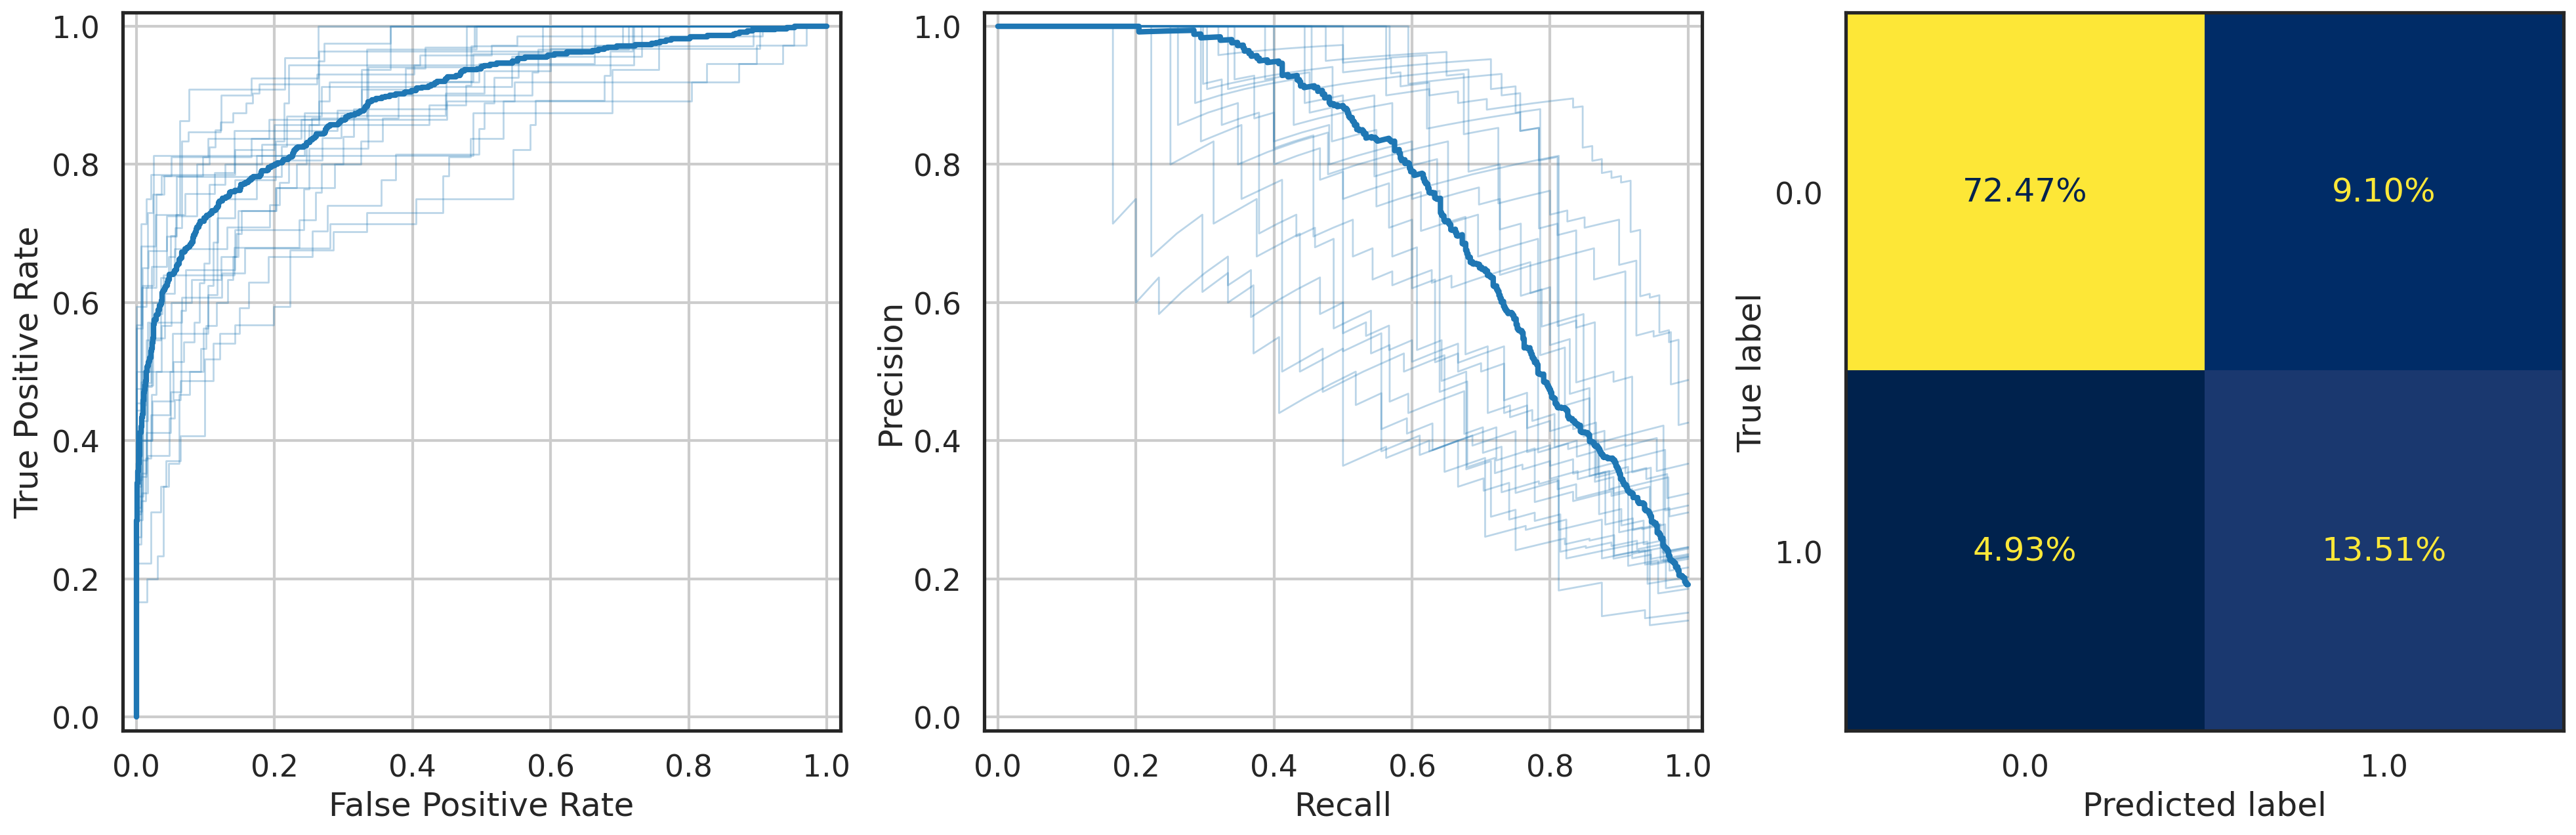

In [16]:
base = 'local/out/exp/' + ts
# mkdirp(base)
print(base)

# T.save(reasoner_original.state_dict(), base+'/reasonerO.pt')
# T.save(reasoner_mod.state_dict(), base+'/reasonerM.pt')

# df_tr = pd.DataFrame(train_logger.history_tr)
# df_vl = pd.DataFrame(train_logger.history_vl)
# df_tr.to_csv(base+'/train.csv', index=False)
# df_vl.to_csv(base+'/valid.csv', index=False)
plot_train_history(df_tr, df_vl, save=base+'/train.png')

test_history_by_onto = pd.DataFrame(test_logger.history_vl_by_onto)
test_history = pd.DataFrame(test_logger.history_vl)
test_results = pd.DataFrame(dict(idx_te=idx_te, y_te=y_te, Y_te_orig=Y_te_orig, Y_te_mod=Y_te_mod))
test_history.to_csv(base+'/test.csv', index=False)
test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
test_results.to_csv(base+'/test-results.csv', index=False)
plot_test_history(test_history, test_history_by_onto, save=base+'/test.png')
print('original')
print(report(test_onto, y_te, np.array(Y_te_orig), idx_te, save=base+'/%-trained'))
print('modified')
print(report(test_onto, y_te, np.array(Y_te_mod), idx_te, save=base+'/%-random'))

In [17]:
from src.id import print_identity_results
print(print_identity_results(reasoner_original,trained_test_encoders['original reasoner'], seed))

Double Negation:
  Mean Loss: 0.275829
  Std Dev Loss: 0.032076
  Mean Diff: 0.572563
  Std Dev Diff: 0.098696

Duality of Top and Bottom:
  Mean Loss: 0.375272
  Std Dev Loss: 0.000000
  Mean Diff: 0.763538
  Std Dev Diff: 0.000000

Idempotence:
  Mean Loss: 0.124807
  Std Dev Loss: 0.031839
  Mean Diff: 0.305517
  Std Dev Diff: 0.082982

Associativity:
  Mean Loss: 0.034179
  Std Dev Loss: 0.012141
  Mean Diff: 0.077771
  Std Dev Diff: 0.026644

Commutativity:
  Mean Loss: 0.037886
  Std Dev Loss: 0.012841
  Mean Diff: 0.088414
  Std Dev Diff: 0.032835

Contradiction:
  Mean Loss: 0.385552
  Std Dev Loss: 0.014225
  Mean Diff: 0.821094
  Std Dev Diff: 0.067127

Identity with Top:
  Mean Loss: 0.143166
  Std Dev Loss: 0.036838
  Mean Diff: 0.352388
  Std Dev Diff: 0.117444

Absorption by Bottom:
  Mean Loss: 0.447209
  Std Dev Loss: 0.019596
  Mean Diff: 0.838424
  Std Dev Diff: 0.043596

Top Concept Subsumption:
  Mean Loss: 0.001424
  Std Dev Loss: 0.001522
  Mean Diff: N/A
  Std De

In [18]:
print(print_identity_results(reasoner_mod,trained_test_encoders['modified reasoner'], seed))

Double Negation:
  Mean Loss: 0.000029
  Std Dev Loss: 0.000011
  Mean Diff: 0.000075
  Std Dev Diff: 0.000035

Duality of Top and Bottom:
  Mean Loss: 0.000255
  Std Dev Loss: 0.000000
  Mean Diff: 0.000465
  Std Dev Diff: 0.000000

Idempotence:
  Mean Loss: 0.116455
  Std Dev Loss: 0.028063
  Mean Diff: 0.270189
  Std Dev Diff: 0.075154

Associativity:
  Mean Loss: 0.020916
  Std Dev Loss: 0.007084
  Mean Diff: 0.047292
  Std Dev Diff: 0.015881

Commutativity:
  Mean Loss: 0.023980
  Std Dev Loss: 0.008702
  Mean Diff: 0.056571
  Std Dev Diff: 0.021047

Contradiction:
  Mean Loss: 0.144091
  Std Dev Loss: 0.035467
  Mean Diff: 0.236603
  Std Dev Diff: 0.040964

Identity with Top:
  Mean Loss: 0.066419
  Std Dev Loss: 0.018071
  Mean Diff: 0.159155
  Std Dev Diff: 0.050295

Absorption by Bottom:
  Mean Loss: 0.020126
  Std Dev Loss: 0.009164
  Mean Diff: 0.051244
  Std Dev Diff: 0.020814

Top Concept Subsumption:
  Mean Loss: 0.000847
  Std Dev Loss: 0.000852
  Mean Diff: N/A
  Std De